In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from collections import defaultdict
from pathlib import Path
import json
import random

In [33]:
from kg.utils.constants import EXPERIMENTS_DIR
from kg.plotting.plotting import find_results_files, organize_results, plot_metric

In [42]:
base_experiments_dir = EXPERIMENTS_DIR
base_experiments_dir = Path("/net/projects/clab/tnief/knowledge-grafting/experiments")
layers_setting = "selective_layers_reversal"
layers_setting = "all_layers"
base_experiments_dir = base_experiments_dir / layers_setting
base_experiments_dir

PosixPath('/net/projects/clab/tnief/knowledge-grafting/experiments/all_layers')

In [43]:
allow_smoke_test = False
all_my_results_files = find_results_files(base_experiments_dir, allow_smoke_test)

Found 8 'results.json' files.


In [44]:
all_my_results_files

[PosixPath('/net/projects/clab/tnief/knowledge-grafting/experiments/all_layers/lm_head_never/counterfact/pythia-2.8b/sft2pre/fe_lt_complement/A2B_2025-05-27_15-06-21_checkpoint-26304_2025-06-07_18-06-01/counterfact_sentence/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/knowledge-grafting/experiments/all_layers/lm_head_never/counterfact/pythia-2.8b/sft2pre/no_patching/A2B_2025-05-27_15-06-21_checkpoint-26304_2025-06-07_18-05-54/counterfact_sentence/no_patching/results.json'),
 PosixPath('/net/projects/clab/tnief/knowledge-grafting/experiments/all_layers/lm_head_never/counterfact/pythia-2.8b/sft2pre/not_lt/A2B_2025-05-27_15-06-21_checkpoint-26304_2025-06-07_18-06-04/counterfact_sentence/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/knowledge-grafting/experiments/all_layers/lm_head_never/counterfact/pythia-2.8b/sft2pre/fe/A2B_2025-05-27_15-06-21_checkpoint-26304_2025-06-07_18-05-56/counterfact_sentence/dropout_0.0_layer_count/r

In [45]:
organized_results = organize_results(all_my_results_files, base_experiments_dir)

Attempted to parse 8 files.
Successfully parsed 8 paths and calculated metrics for 8.
Organized data into 1 datasets.


In [46]:
organized_results

defaultdict(<function kg.plotting.plotting.organize_results.<locals>.<lambda>()>,
            {'counterfact': defaultdict(<function kg.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'lm_head_never': defaultdict(<function kg.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'pythia-2.8b': defaultdict(dict,
                                                   {'counterfact_sentence': {'fe_lt_complement': {'mean_target_rank': np.float64(514.975),
                                                      'top_k_accuracy': np.float64(0.001),
                                                      'mean_target_prob': np.float64(0.0003798306130097444)},
                                                     'no_patching_sft2pre': {'mean_target_rank': np.float64(307.659),
                                                      'top_k_accuracy': np.float64(0.005),
        

In [47]:
organized_results['counterfact']

defaultdict(<function kg.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>()>,
            {'lm_head_never': defaultdict(<function kg.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'pythia-2.8b': defaultdict(dict,
                                      {'counterfact_sentence': {'fe_lt_complement': {'mean_target_rank': np.float64(514.975),
                                         'top_k_accuracy': np.float64(0.001),
                                         'mean_target_prob': np.float64(0.0003798306130097444)},
                                        'no_patching_sft2pre': {'mean_target_rank': np.float64(307.659),
                                         'top_k_accuracy': np.float64(0.005),
                                         'mean_target_prob': np.float64(0.0009621135051299916)},
                                        'not_lt': {'mean_target_rank': np.float64(906.771),
                    

In [48]:
dataset_name = "counterfact"
lm_head_setting = "lm_head_never"
filtered_data = {
    dataset: {
        lm_head_setting: models[lm_head_setting]
    }
    for dataset, models in organized_results.items()
    if dataset == dataset_name and lm_head_setting in models
}

In [49]:
filtered_data

{'counterfact': {'lm_head_never': defaultdict(<function kg.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
              {'pythia-2.8b': defaultdict(dict,
                           {'counterfact_sentence': {'fe_lt_complement': {'mean_target_rank': np.float64(514.975),
                              'top_k_accuracy': np.float64(0.001),
                              'mean_target_prob': np.float64(0.0003798306130097444)},
                             'no_patching_sft2pre': {'mean_target_rank': np.float64(307.659),
                              'top_k_accuracy': np.float64(0.005),
                              'mean_target_prob': np.float64(0.0009621135051299916)},
                             'not_lt': {'mean_target_rank': np.float64(906.771),
                              'top_k_accuracy': np.float64(0.001),
                              'mean_target_prob': np.float64(0.00038359928429650836)},
                             'fe': {'mean_target_r

In [50]:
def filter_by_sentence(data, sentence):
    # Deeply traverse the nested defaultdict structure
    filtered_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
    
    for dataset, models in data.items():
        for model_type, model_dict in models.items():
            for model_name, sentence_dict in model_dict.items():
                if sentence in sentence_dict:
                    filtered_data[dataset][model_type][model_name][sentence] = sentence_dict[sentence]
    
    return filtered_data

# sentence = "sentence_1"
# filtered_data = filter_by_sentence(filtered_data, sentence)

In [51]:
def format_result(result):
    """Format a single result as simple token-probability pairs"""
    output = []
    # Add target first with explicit label
    output.append(f"Target: {result['target']['token']}: {result['target']['token_prob']:.3f}")
    # Add top 10 predictions
    for pred in result['top_predictions'][:10]:
        output.append(f"{pred['token']}: {pred['probability']:.3f}")
    return "\n".join(output)

# Load results from the specified path
results_path = base_experiments_dir / 'lm_head_never' / 'fake_movies_real_actors' / 'gemma' / 'sft2pre' / 'not_fe' / 'all_2025-05-07_21-51-20_best_saved_checkpoint_2025-05-20_12-02-35' / 'sentence_1' / 'dropout_0.0_layer_count' / 'results.json'
results_path = Path('/net/projects/clab/tnief/knowledge-grafting/experiments/all_layers/lm_head_never/fake_movies_real_actors/gpt2-xl/sft2pre/fe_lt_complement/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-20_12-01-54/sentence_1/dropout_0.0_layer_count/results.json')

with open(results_path, 'r') as f:
    data = json.load(f)
    results = data.get('results', [])

# Sample 5 random results
if results:
    sampled_results = random.sample(results, min(5, len(results)))
    print(f"Found {len(results)} total results. Displaying 5 random samples:\n")
    
    for i, result in enumerate(sampled_results, 1):
        print(f"Example {i}:")
        print(format_result(result))
        print("\n" + "-"*40 + "\n")
else:
    print("No results found in the specified file")

FileNotFoundError: [Errno 2] No such file or directory: '/net/projects/clab/tnief/knowledge-grafting/experiments/all_layers/lm_head_never/fake_movies_real_actors/gpt2-xl/sft2pre/fe_lt_complement/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-20_12-01-54/sentence_1/dropout_0.0_layer_count/results.json'

In [53]:
core_patches_only = False
short_title = False
save = False

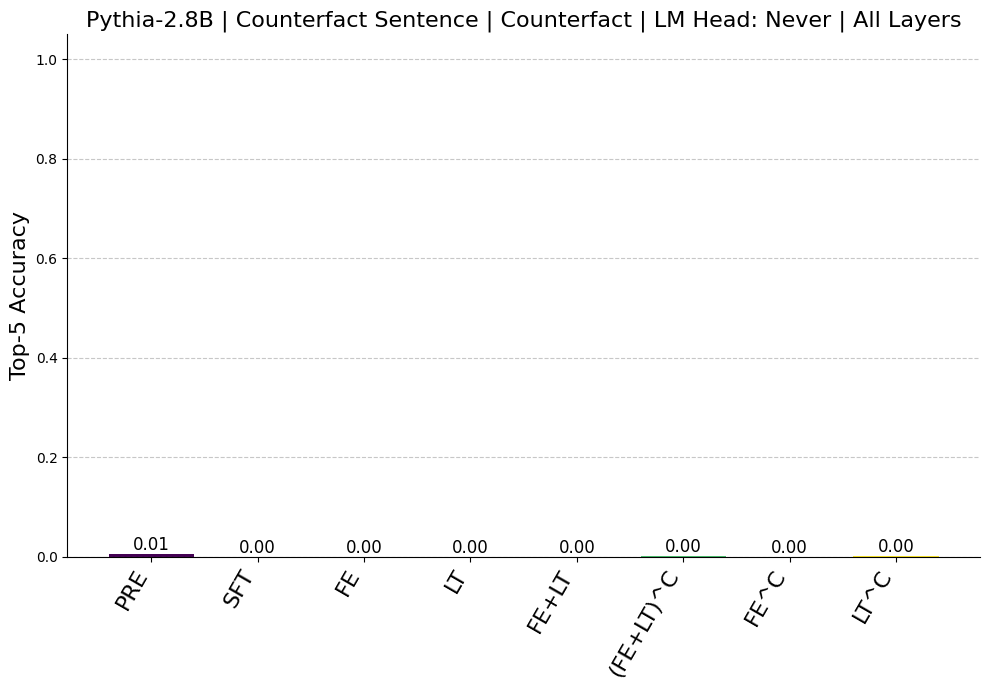

In [54]:
metric_key = "top_k_accuracy"
plot_metric(filtered_data, metric_key, layers_setting=layers_setting, save=save, core_patches_only=core_patches_only, short_title=short_title)

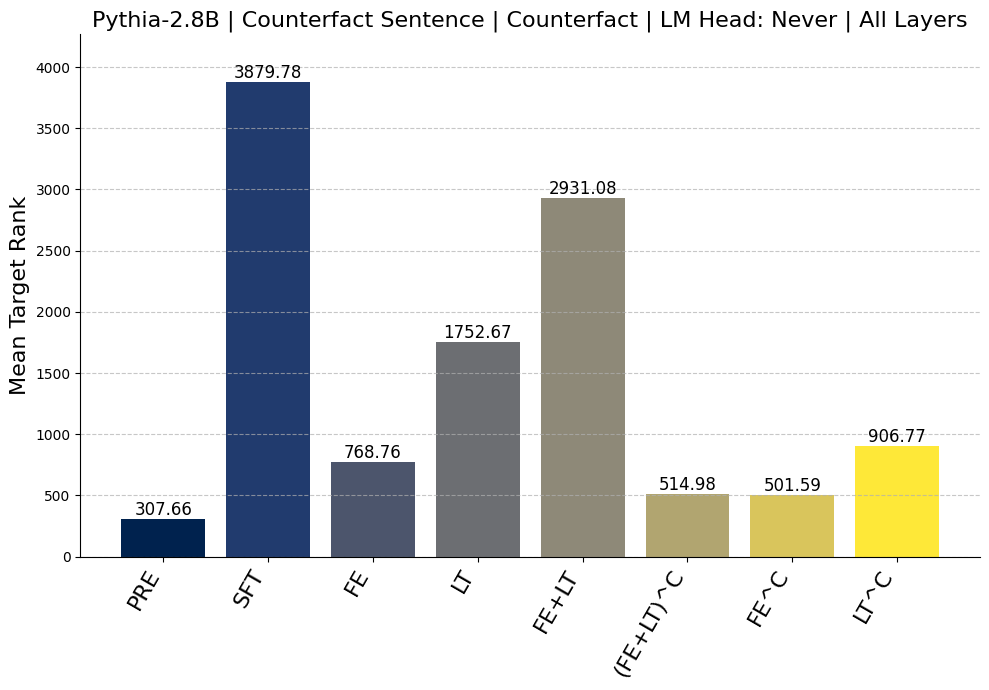

In [55]:
metric_key = "mean_target_rank"
plot_metric(organized_results, metric_key, layers_setting=layers_setting, save=save, core_patches_only=core_patches_only, short_title=short_title)

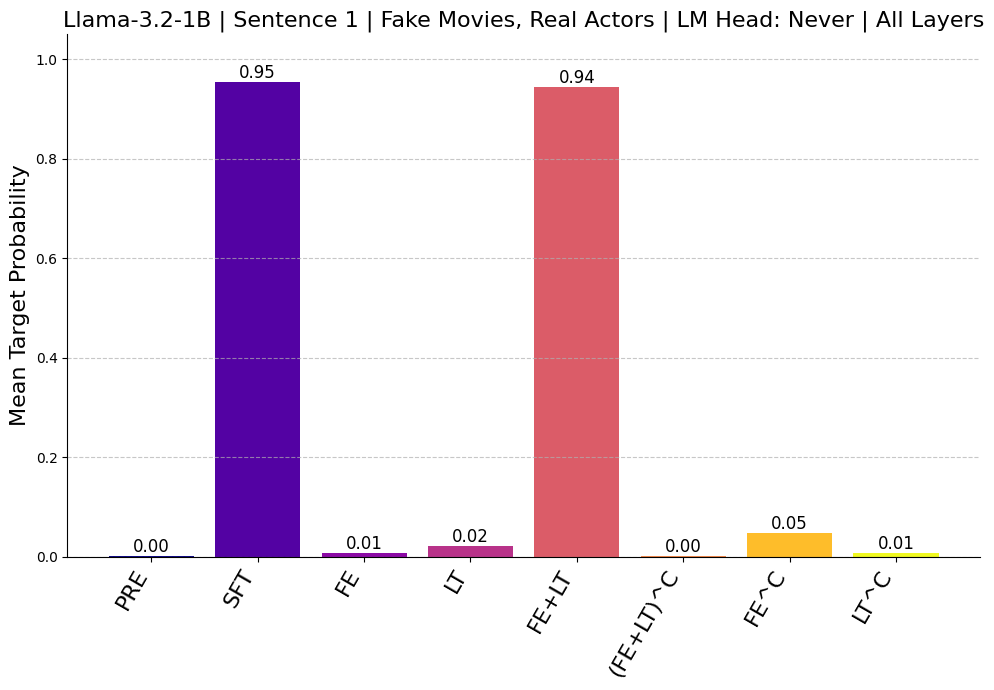

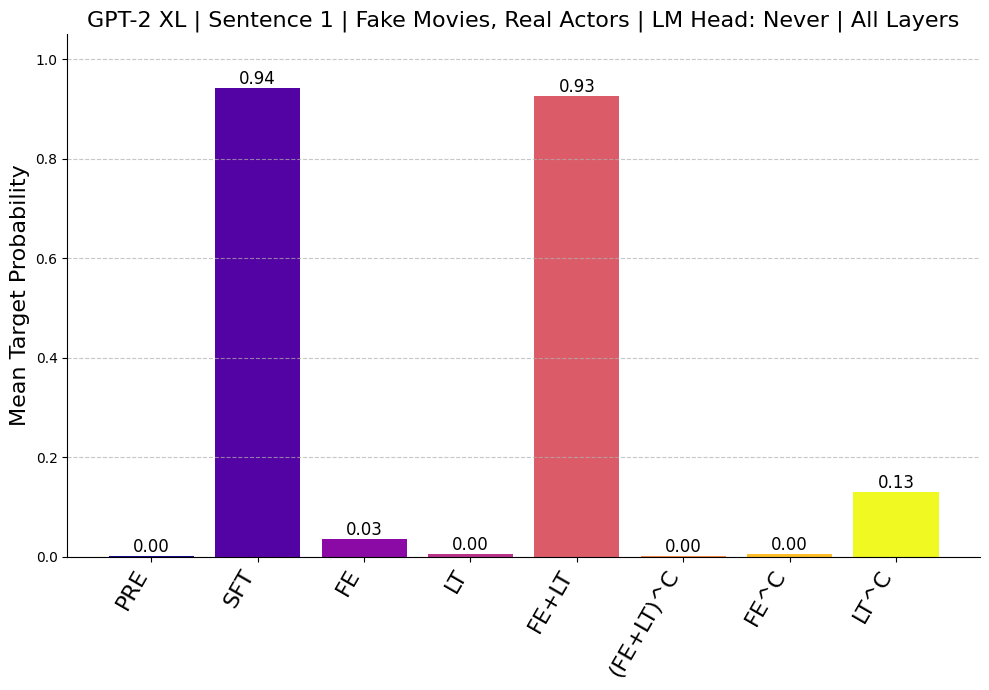

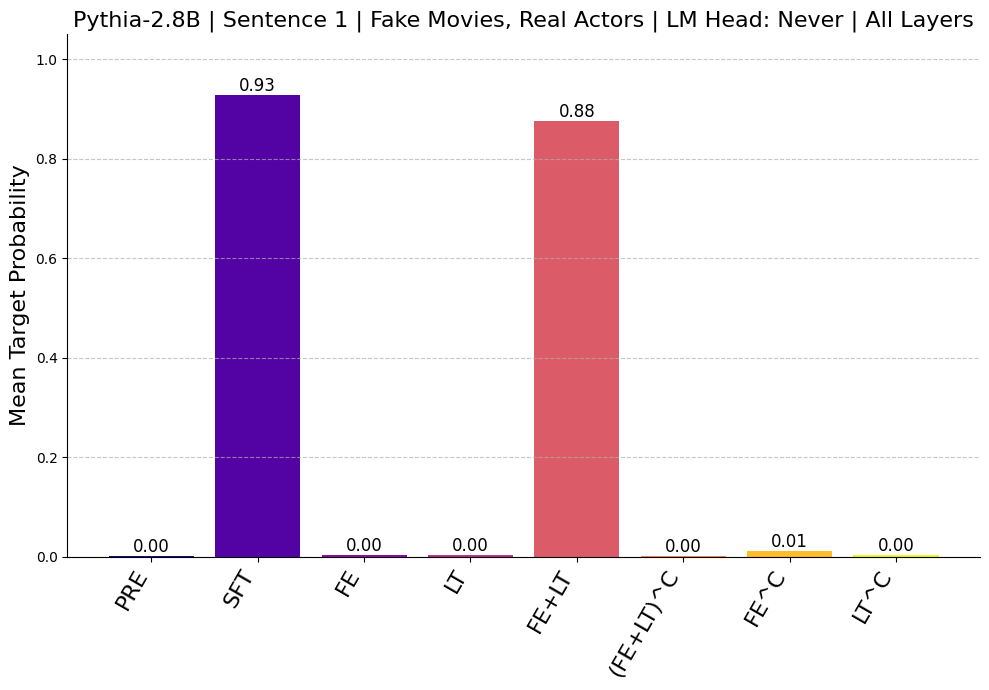

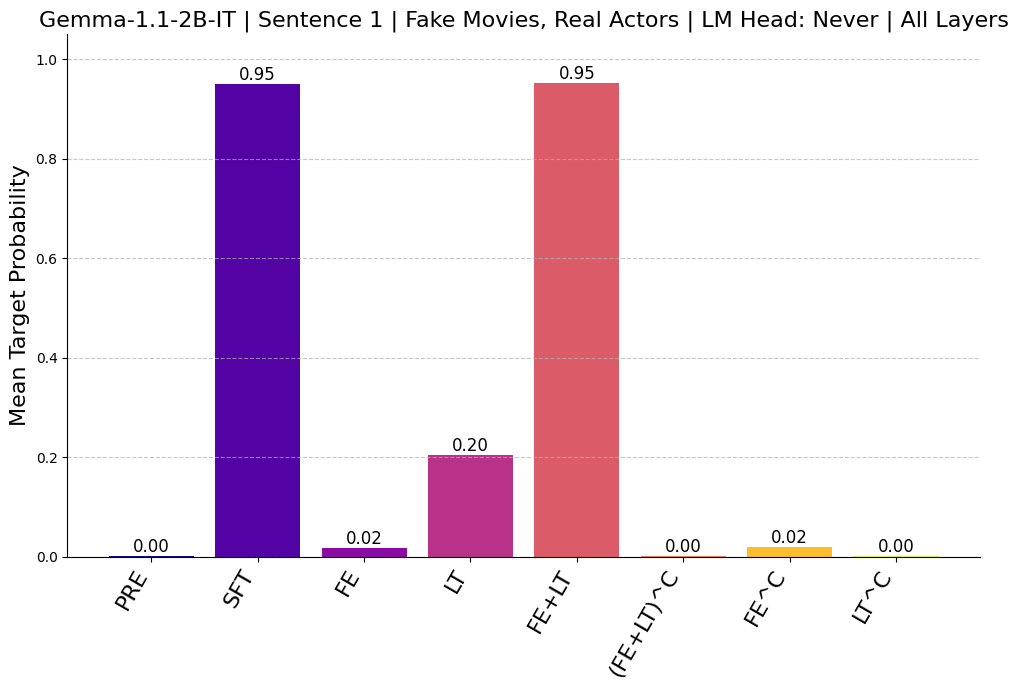

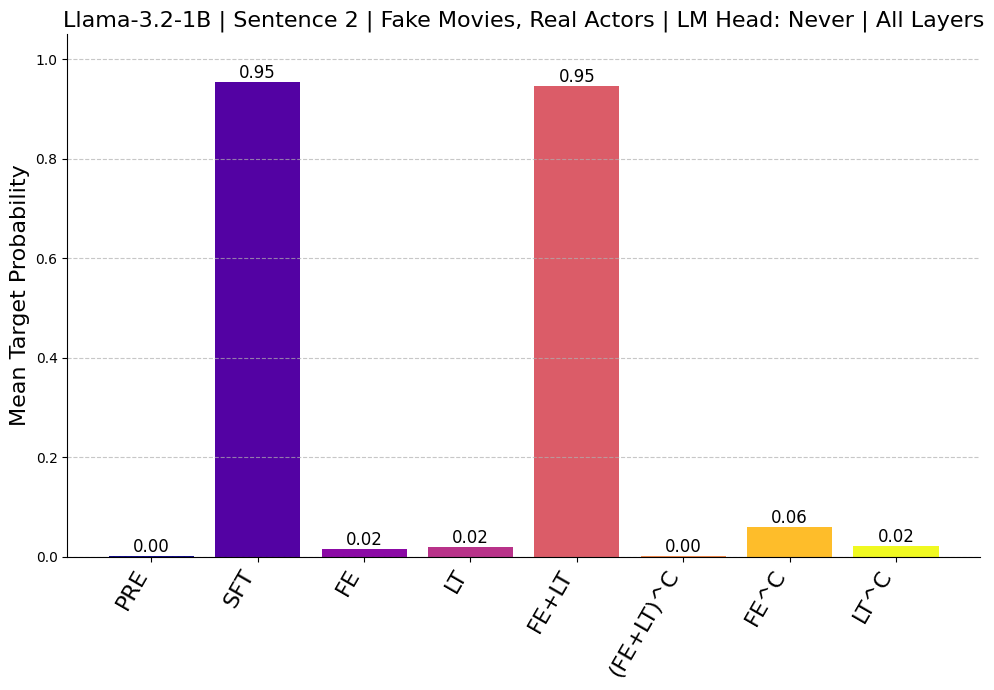

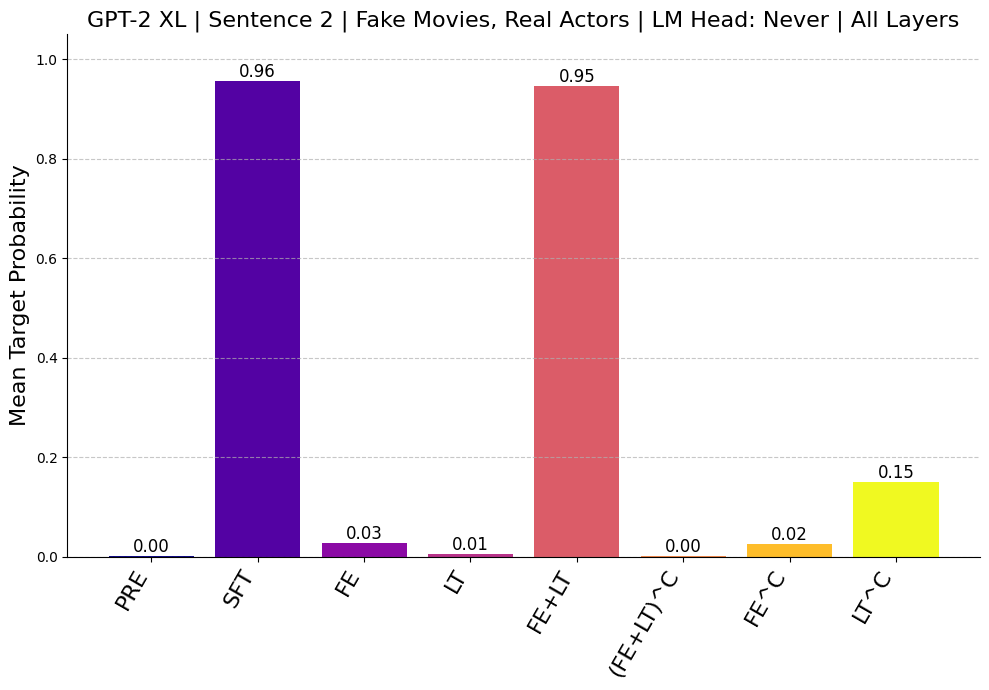

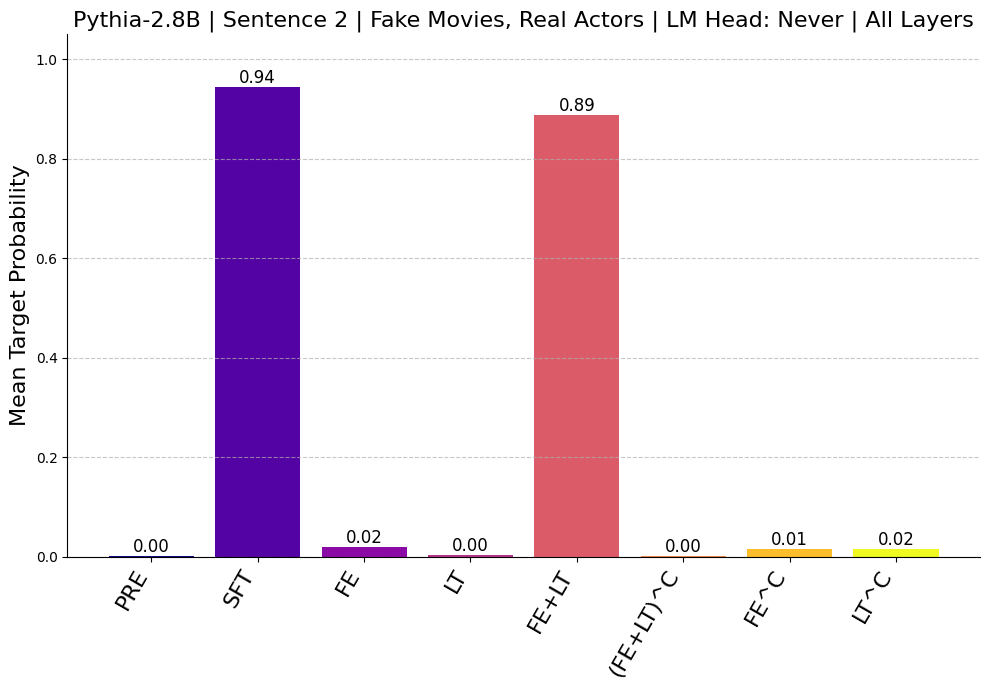

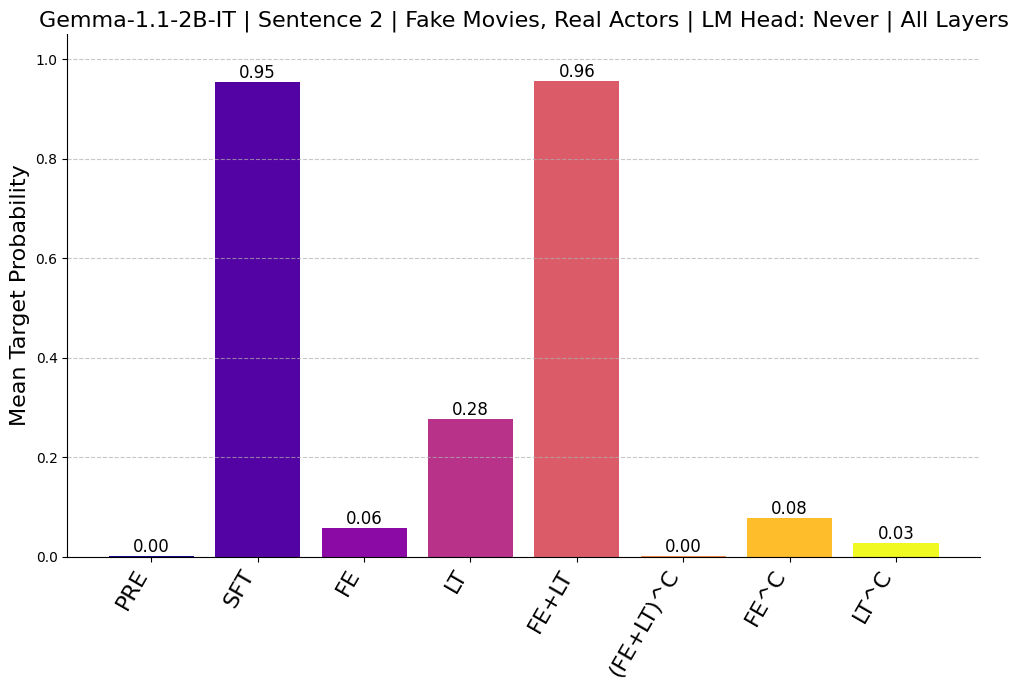

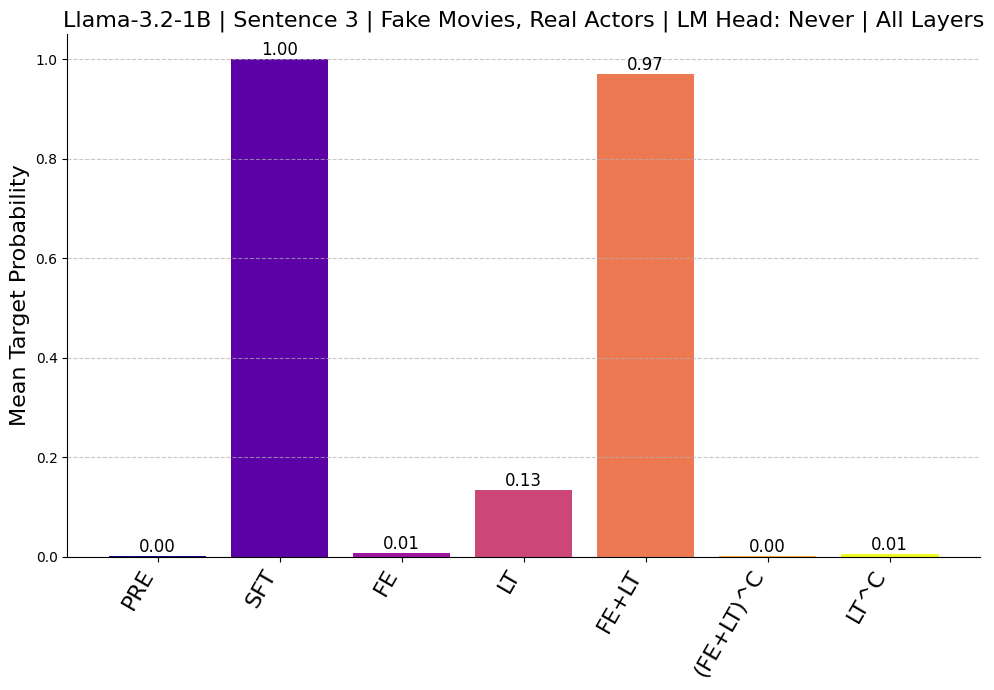

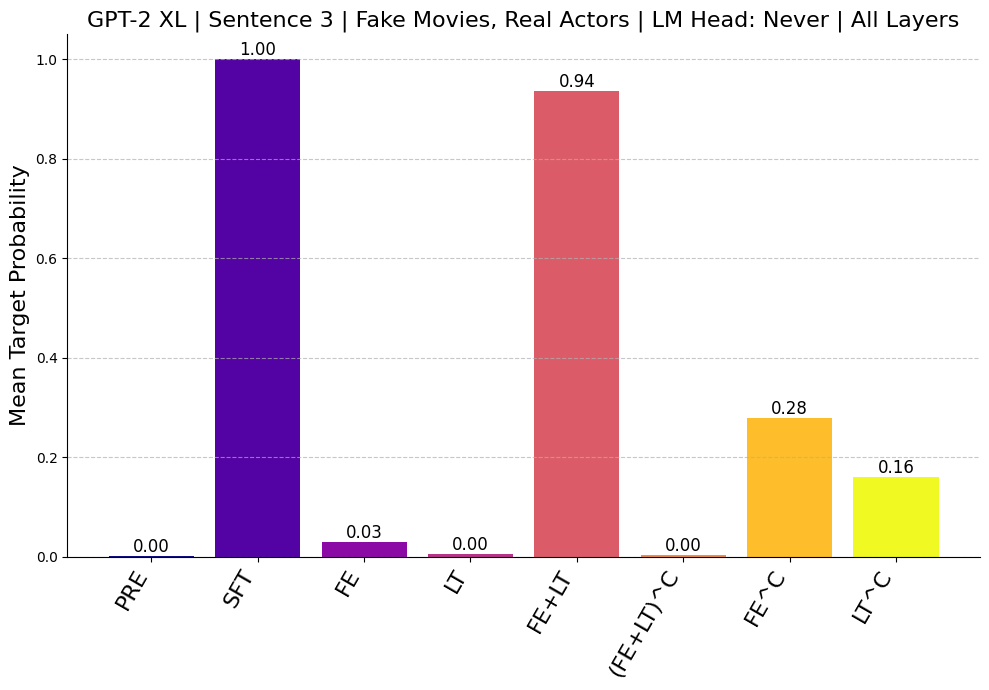

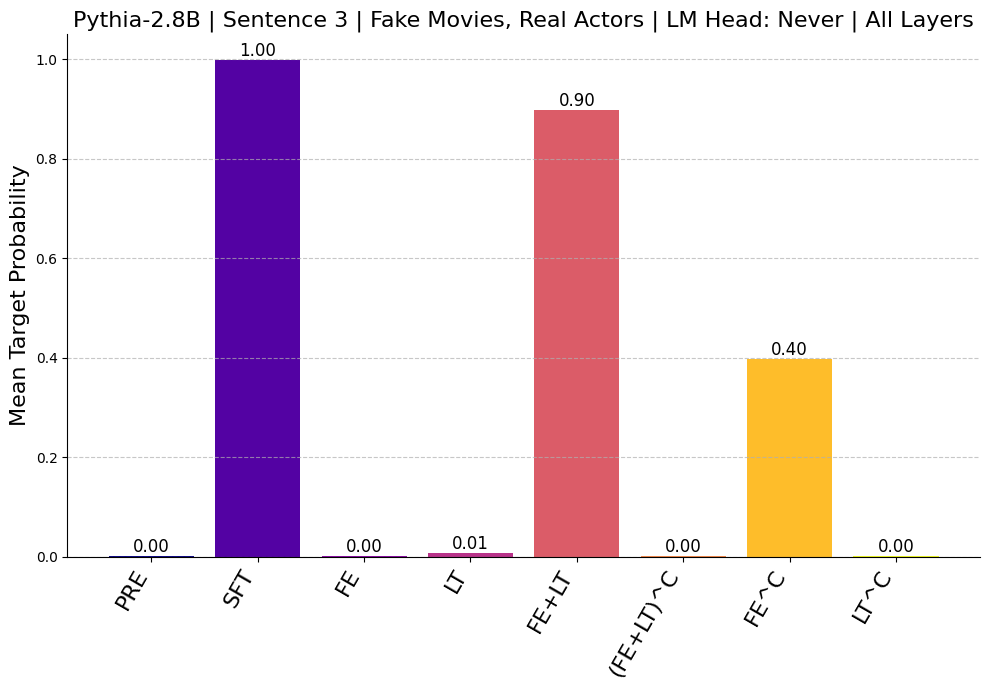

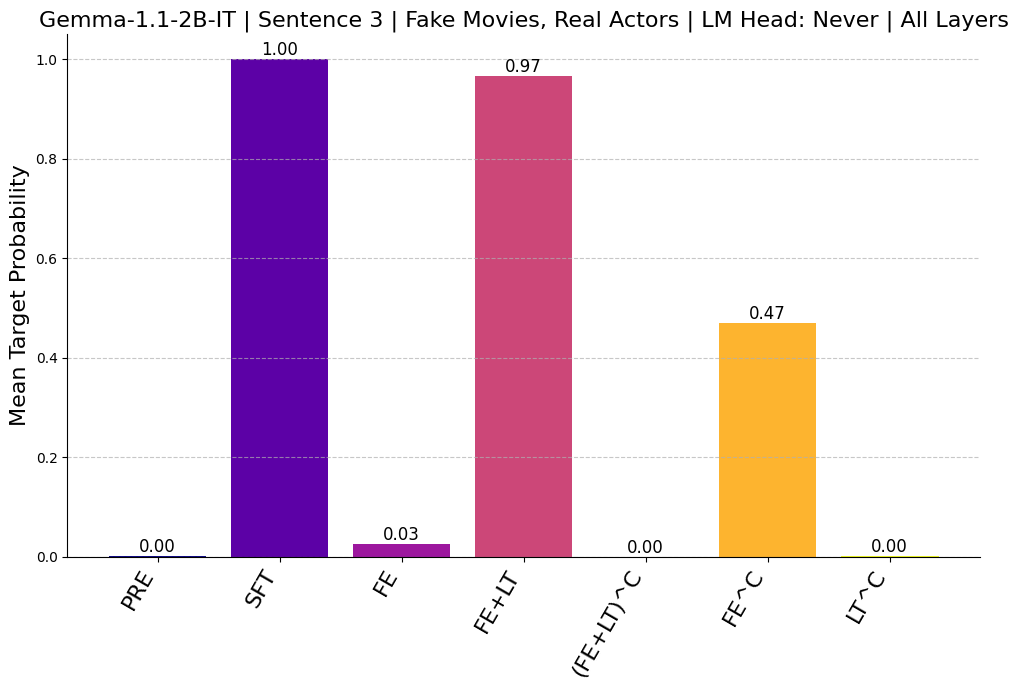

In [30]:
metric_key = "mean_target_prob"
plot_metric(organized_results, metric_key, layers_setting=layers_setting, save=save, core_patches_only=core_patches_only, short_title=short_title)